In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from unsloth import FastLanguageModel
import wandb
import random
from tqdm import tqdm

c:\Users\abhip\.conda\envs\llm\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [2]:
SFT_MODEL_PATH = "./sft_model/fine_tuned_SIFT_model"
DPO_MODEL_PATH = "./dpo_model/fine_tuned_dpo_model"
DATASET_NAME = "argilla/ultrafeedback-binarized-preferences"
WANDB_LOG_DIR_SFT = "./sft_model/wandb/latest-run"
WANDB_LOG_DIR_DPO = "./dpo_model/wandb/latest-run"
MAX_GEN_TOKENS = 256

In [3]:
# api = wandb.Api()
# dpo_run = api.run("abhipodila1-student/huggingface/wnya45wg")
# sft_run = api.run("abhipodila1-student/huggingface/28uvelw8")
# dpo_metrics_dataframe = dpo_run.history()
# sft_metrics_dataframe = sft_run.history()
# dpo_metrics_dataframe.to_csv("dpo_metrics.csv")
# sft_metrics_dataframe.to_csv("sft_metrics.csv")

In [4]:
RANDOM_SEED = 55
NUM_SAMPLES = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device

device(type='cuda')

In [5]:
data = load_dataset(DATASET_NAME, split="train")
eval_data = data.shuffle(seed=RANDOM_SEED).select(range(NUM_SAMPLES))

def generate_response(model, tokenizer, prompt, max_length=MAX_GEN_TOKENS):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_length,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
        )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
sft_model, sft_tokenizer = FastLanguageModel.from_pretrained(SFT_MODEL_PATH)

c:\Users\abhip\.conda\envs\llm\lib\site-packages\unsloth_zoo\gradient_checkpointing.py:339: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  GPU_BUFFERS = tuple([torch.empty(2*256*2048, dtype = dtype, device = f"{DEVICE_TYPE}:{i}") for i in range(n_gpus)])


==((====))==  Unsloth 2025.7.3: Fast Llama patching. Transformers: 4.53.2.
   \\   /|    NVIDIA GeForce RTX 4050 Laptop GPU. Num GPUs = 1. Max memory: 5.997 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.3.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.31.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2025.7.3 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


In [7]:
sft_model = sft_model.to(device).eval()
results = []

In [8]:
for example in tqdm(eval_data):
    prompt = example["instruction"]
    sft_response = generate_response(sft_model, sft_tokenizer, prompt)
    results.append({"prompt": prompt, "sft_response": sft_response})

100%|██████████| 50/50 [22:45<00:00, 27.30s/it]


In [9]:
import gc
del sft_model
del sft_tokenizer
torch.cuda.empty_cache()
gc.collect()

37875

In [10]:
dpo_model, dpo_tokenizer = FastLanguageModel.from_pretrained(DPO_MODEL_PATH)
dpo_model = dpo_model.to(device).eval()

==((====))==  Unsloth 2025.7.3: Fast Llama patching. Transformers: 4.53.2.
   \\   /|    NVIDIA GeForce RTX 4050 Laptop GPU. Num GPUs = 1. Max memory: 5.997 GB. Platform: Windows.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.3.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.31.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [11]:
for r in (tqdm(results)):
    prompt = r["prompt"]
    dpo_response = generate_response(dpo_model, dpo_tokenizer, prompt)
    r["dpo_response"] = dpo_response

100%|██████████| 50/50 [08:59<00:00, 10.79s/it]


In [12]:
del dpo_model
del dpo_tokenizer
torch.cuda.empty_cache()
gc.collect()

37875

In [13]:
REWARD_MODEL_NAME = "OpenAssistant/reward-model-deberta-v3-large"
SAVE_FILE = "response_results.json"

In [14]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [15]:
reward_model = AutoModelForSequenceClassification.from_pretrained(REWARD_MODEL_NAME)
reward_model = reward_model.to(device).eval()
reward_tokenizer = AutoTokenizer.from_pretrained(REWARD_MODEL_NAME)

In [16]:
def score_response(prompt, response):
    text = prompt + "\n" + response
    inputs = reward_tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        score = reward_model(**inputs).logits[0].item()
    return score

In [17]:
results[-1]

{'prompt': 'Teacher: One of the following sentences is nonsensical. Which one is it?\nOptions:\n- Sentence A: "For breakfast, I like to eat a boiled egg on toast."\n- Sentence B: "For breakfast, I like to eat a boiled shoe on toast."\n\nStudent: Shoes are not good to eat for breakfast.\nThe answer is Sentence B.\n\nquestion in book:\nChoose the sentence that goes against common sense.\nOptions:\n- Sentence A: "People can row boats."\n- Sentence B: "Boats can row people."\n\nstandard solution:\nBoats are inanimate objects that can\'t do anything, let alone to people.\nThe answer is Sentence B.\n\n[TEACHER] Which of the following sentences is nonsensical?\nOptions:\n- Sentence A: "She put on underwear, then pants."\n- Sentence B: "She put on pants, then underwear."\n\n[Student] Underwear has to be put on before pants.\nThe answer is Sentence B.\n\nTeacher: Which of the following two sentences does not make sense?\nOptions:\n- Sentence A: "The dish is too spicy since I just added too much

In [18]:
for r in tqdm(results):
    r["sft_score"] = score_response(r["prompt"], r["sft_response"])
    r["dpo_score"] = score_response(r["prompt"], r["dpo_response"])

100%|██████████| 50/50 [00:10<00:00,  4.88it/s]


In [19]:
import json

with open(SAVE_FILE, "w") as f:
    json.dump(results, f, indent=2)

In [20]:
#Find mean of both scores
dpo_wins = sum(r["dpo_score"] > r["sft_score"] for r in results)
draws = sum(r["dpo_score"] == r["sft_score"] for r in results)
win_rate = dpo_wins / len(results)
draw_rate = draws / len(results)

avg_sft_score = np.mean([r["sft_score"] for r in results])
avg_dpo_score = np.mean([r["dpo_score"] for r in results])
score_gap = avg_dpo_score - avg_sft_score

print("\n===== Performance Summary =====")
print(f"Win Rate (DPO > SFT): {win_rate:.2%}")
print(f"Draw Rate (DPO = SFT): {draw_rate:.2%}")
print(f"Average SFT Score:    {avg_sft_score:.3f}")
print(f"Average DPO Score:    {avg_dpo_score:.3f}")
print(f"Score Gap:            {score_gap:.3f}")


===== Performance Summary =====
Win Rate (DPO > SFT): 52.00%
Draw Rate (DPO = SFT): 26.00%
Average SFT Score:    0.140
Average DPO Score:    2.012
Score Gap:            1.871


In [21]:
# Save performance summary to json file

import json
with open("performance_metrics.json", "w") as f:
    json.dump(results, f, indent=2)



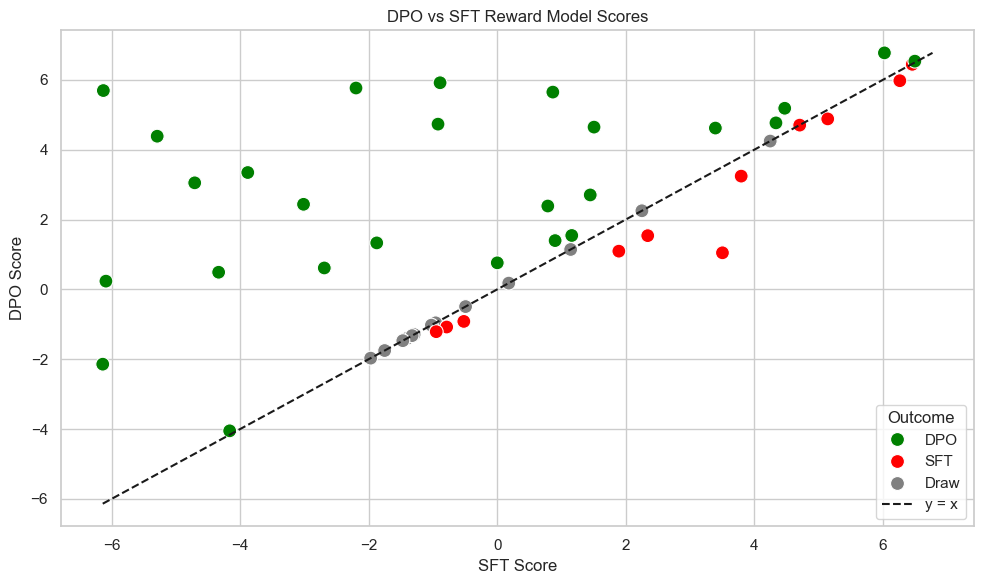

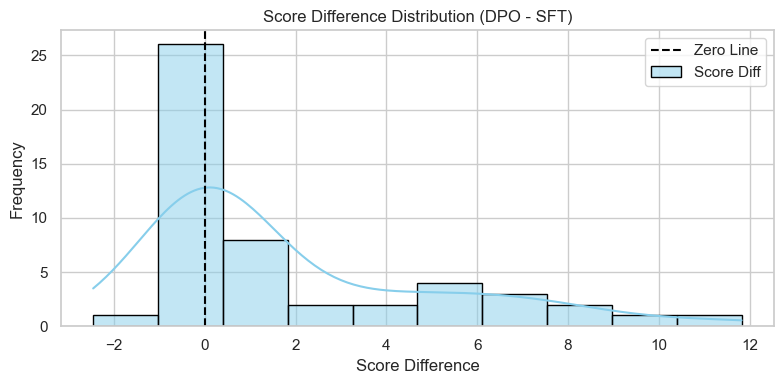

C:\Users\abhip\AppData\Local\Temp\ipykernel_25524\1814990090.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["SFT", "DPO"], y=[avg_sft_score, avg_dpo_score], palette=["red", "green"])


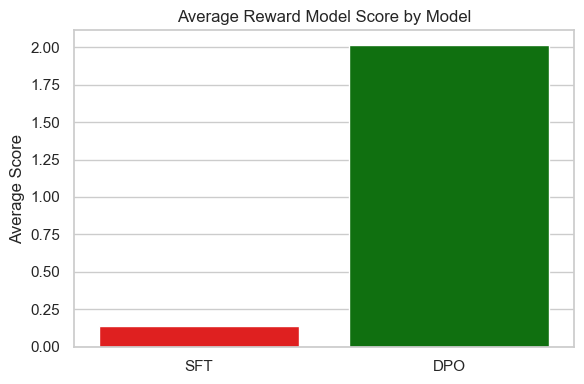

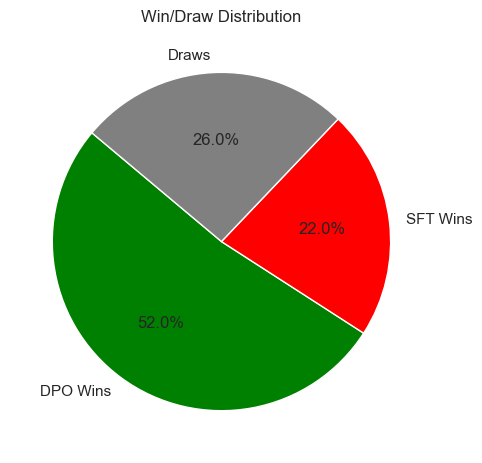

In [22]:
import seaborn as sns

scores_df = pd.DataFrame(results)
scores_df["label"] = scores_df.apply(lambda r: "DPO" if r["dpo_score"] > r["sft_score"] else "SFT" if r["sft_score"] > r["dpo_score"] else "Draw", axis=1)
scores_df["diff"] = scores_df["dpo_score"] - scores_df["sft_score"]

# === Scatter Plot (DPO vs SFT) ===
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=scores_df, x="sft_score", y="dpo_score", hue="label", palette={"DPO": "green", "SFT": "red", "Draw": "gray"}, s=100)
plt.plot([scores_df[["sft_score", "dpo_score"]].min().min(), scores_df[["sft_score", "dpo_score"]].max().max()],
         [scores_df[["sft_score", "dpo_score"]].min().min(), scores_df[["sft_score", "dpo_score"]].max().max()], 'k--', label="y = x")
plt.xlabel("SFT Score")
plt.ylabel("DPO Score")
plt.title("DPO vs SFT Reward Model Scores")
plt.legend(title="Outcome")
plt.tight_layout()
plt.show()

# === Score Difference Distribution ===
plt.figure(figsize=(8, 4))
sns.histplot(scores_df["diff"], bins=10, kde=True, color="skyblue", edgecolor="black", label="Score Diff")
plt.axvline(0, color="black", linestyle="--", label="Zero Line")
plt.legend()
plt.title("Score Difference Distribution (DPO - SFT)")
plt.xlabel("Score Difference")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# === Average Score Bar Plot ===
plt.figure(figsize=(6, 4))
sns.barplot(x=["SFT", "DPO"], y=[avg_sft_score, avg_dpo_score], palette=["red", "green"])
plt.title("Average Reward Model Score by Model")
plt.ylabel("Average Score")
plt.tight_layout()
plt.show()

# === Win/Draw Distribution Pie Chart ===
plt.figure(figsize=(5, 5))
plt.pie([dpo_wins, len(results) - dpo_wins - draws, draws], labels=["DPO Wins", "SFT Wins", "Draws"],
        colors=["green", "red", "gray"], autopct='%1.1f%%', startangle=140)
plt.title("Win/Draw Distribution")
plt.tight_layout()
plt.show()